Kernel : base (Python 3.9.7) conda environnement

# I. INSTALLER ENVIRONNEMENT DE TRAVAIL

Installer packages/librairies nécessaires

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
from os import listdir
import missingno as msno
from zipfile import ZipFile
import requests
import math
from numpy import loadtxt

Definir l'environnement de travail

In [2]:
path_to_dir=os.path.abspath(os.getcwd())

Lister tous les fichiers csv presents dans le repertoire de travail.

In [3]:
def csv_files(path_to_dir=path_to_dir, suffix=".csv"):
    filenames = listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

In [4]:
csv_files()

['2016_Building_Energy_Benchmarking.csv',
 '2016_Building_Energy_Benchmarking_info.csv',
 'df19.csv',
 'MLs_compared_Log2_GHGEmissionsIntensity_all.csv',
 'MLs_compared_Log2_SiteEUIWN_all.csv']

# II. OUVERTURE ET BREF EDA DU DF

II.1 Créer df à partir du fichier csv fourni par OCR.

In [5]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv', 
sep=',',
quotechar='"')
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


II.2 Récupérer le tableau descriptif des col.

In [6]:
df_supp = pd.read_csv('2016_Building_Energy_Benchmarking_info.csv',
sep=";",
header=0,
encoding='cp1252')
df_supp.insert(0, 'Column_Name', df.columns)
df_supp.head(3)

,Column_Name,Description
0,OSEBuildingID,A unique identifier assigned to each property ...
1,DataYear,Calendar year (January-December) represented b...
2,BuildingType,City of Seattle building type classification.


II.3 Explorer df

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [8]:
df.shape

(3376, 46)

<AxesSubplot:>

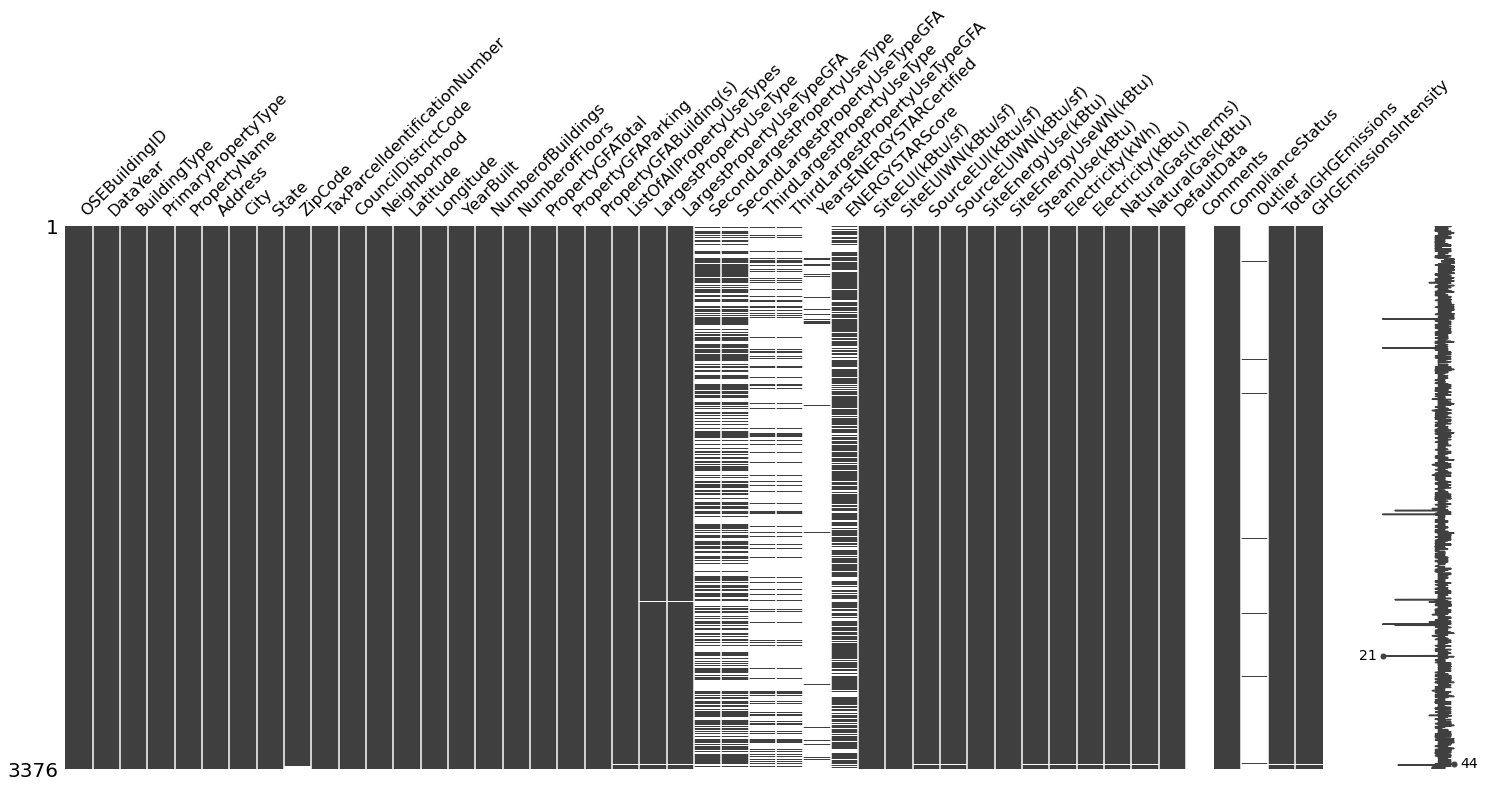

In [9]:
msno.matrix(df)

<AxesSubplot:>

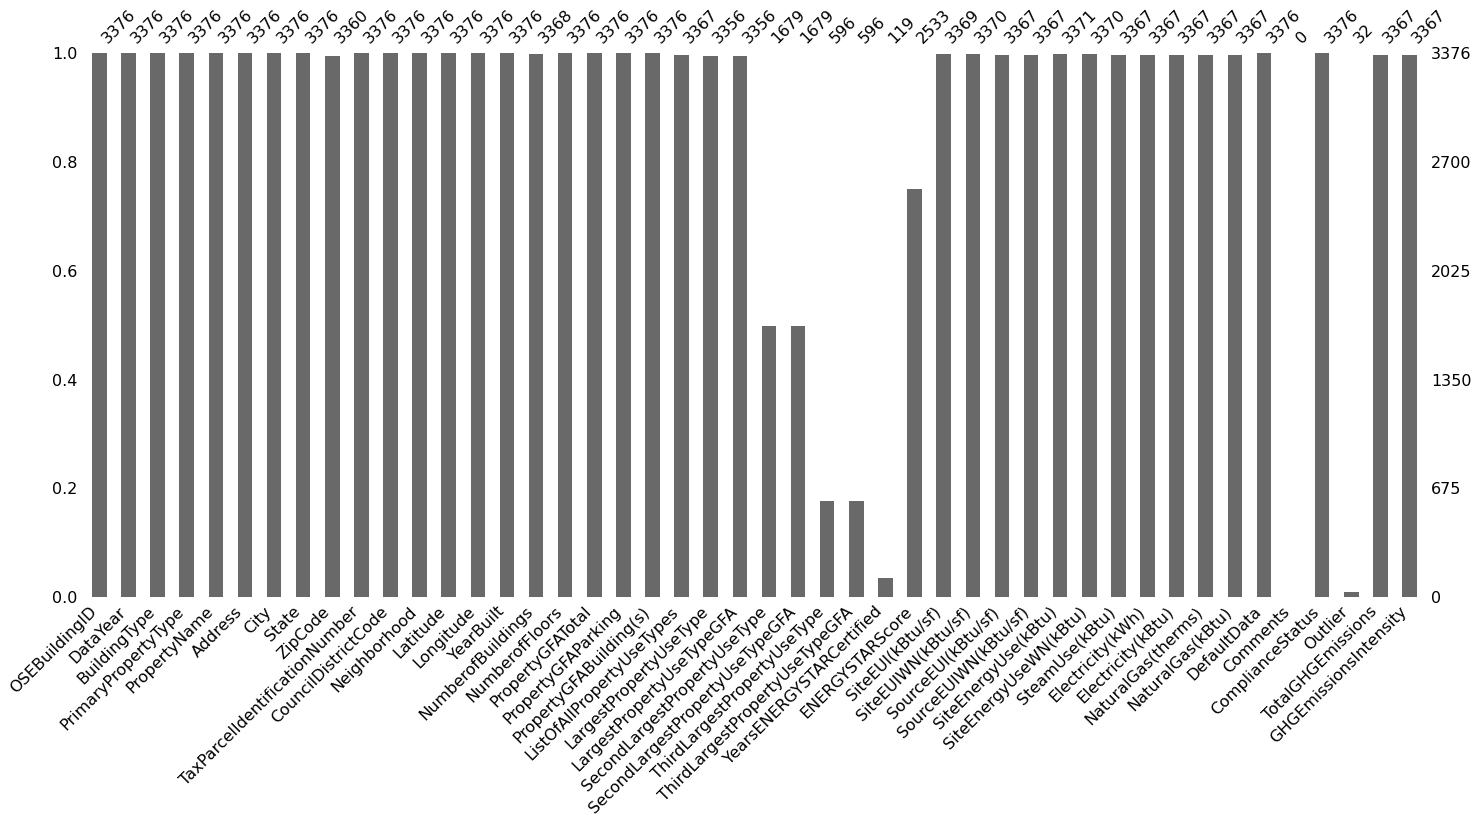

In [10]:
msno.bar(df)

In [11]:
df.isna().sum().sum()

19952

In [12]:
df['City'].unique()

array(['Seattle'], dtype=object)

In [13]:
df['DataYear'].nunique()

1

Rq : col City et DataYear à supprimer (valeur unique)

# III. NETTOYAGE & MISE EN FORME DU DF

III.1 Suppression des col pas utiles (1ère phase)

In [14]:
df2 = df.drop(columns=['OSEBuildingID', 'DataYear', 'City', 'State', 'Comments'])

III.2 Suppression des batiments résidentiels (maisons, résidences, maisons de retraites, campus...)

# /!\ Comme demandé dans le cahier des charges OCR!

In [15]:
df3 = df2[(df2['BuildingType']!='Multifamily MR (5-9)') & 
(df2['BuildingType']!='Multifamily LR (1-4)') &
(df2['BuildingType']!='Multifamily HR (10+)') &
(df2['BuildingType']!='Campus')]

In [16]:
print(f'Suppression de {df2.shape[0]-df3.shape[0]} lignes correspondant à des bâtiments résidentiels.')

Suppression de 1732 lignes correspondant à des bâtiments résidentiels.


In [17]:
df3['BuildingType'].value_counts()

NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [18]:
df3.shape

(1644, 41)

III.3 Suppression des outliers (lignes)

In [19]:
df3['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [20]:
df4 = df3[df3['ComplianceStatus']=='Compliant']

In [21]:
df4.shape

(1524, 41)

III.4 Suppression de col pas utiles ou redondantes (2e phase)

In [22]:
#df4.columns

# /!\ Choix de garder que les col normalisées en WN et normalisées par sf (pour les données consommations)

In [23]:
df5 = df4.drop(columns=['BuildingType', 'Address', 'ZipCode', 'YearsENERGYSTARCertified', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes', 'TotalGHGEmissions',
'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)', 'DefaultData', 'ComplianceStatus', 'Outlier'])

In [24]:
['DefaultData', 'ComplianceStatus', 'Outlier']

['DefaultData', 'ComplianceStatus', 'Outlier']

In [25]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524 entries, 0 to 3375
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1524 non-null   object 
 1   PropertyName                     1524 non-null   object 
 2   CouncilDistrictCode              1524 non-null   int64  
 3   Neighborhood                     1524 non-null   object 
 4   Latitude                         1524 non-null   float64
 5   Longitude                        1524 non-null   float64
 6   YearBuilt                        1524 non-null   int64  
 7   NumberofBuildings                1524 non-null   float64
 8   NumberofFloors                   1524 non-null   int64  
 9   PropertyGFATotal                 1524 non-null   int64  
 10  PropertyGFAParking               1524 non-null   int64  
 11  PropertyGFABuilding(s)           1524 non-null   int64  
 12  LargestPropertyUseTy

III.5 Mise en forme du df5 => df6

# /!\ Organisation : mettre toutes les col à prédire à la fin. 

In [26]:
df6 = df5.copy()

In [27]:
df6.insert(3, 'CouncilDistrictCode', df6.pop('CouncilDistrictCode'))
df6.insert(3, 'LargestPropertyUseType', df6.pop('LargestPropertyUseType'))
df6.insert(4, 'SecondLargestPropertyUseType', df6.pop('SecondLargestPropertyUseType'))
df6.insert(5, 'ThirdLargestPropertyUseType', df6.pop('ThirdLargestPropertyUseType'))

In [28]:
df6.insert(24, "SiteEUIWN(kBtu/sf)", df6.pop('SiteEUIWN(kBtu/sf)'))
df6.insert(23, "SourceEUIWN(kBtu/sf)", df6.pop('SourceEUIWN(kBtu/sf)'))
df6.insert(19, "SteamUse(kBtu/sf)", df6.pop('SteamUse(kBtu)')/df6['PropertyGFABuilding(s)'])
df6.insert(20, "Electricity(kBtu/sf)", df6.pop('Electricity(kBtu)')/df6['PropertyGFABuilding(s)'])
df6.insert(21, 'NaturalGas(kBtu/sf)', df6.pop('NaturalGas(kBtu)')/df6['PropertyGFABuilding(s)'])

#création de 2 nouvelles features
df6.insert(13, "%PropertyGFAParking", df6.pop('PropertyGFAParking')/df6['PropertyGFATotal']*100) #à voir si on le garde plus tard
df6.insert(14, "%PropertyGFABuilding(s)", df6.pop('PropertyGFABuilding(s)')/df6['PropertyGFATotal']*100) #à voir si on le garde plus tard

In [29]:
df6.head(2)

,PrimaryPropertyType,PropertyName,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,...,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu/sf),Electricity(kBtu/sf),NaturalGas(kBtu/sf),GHGEmissionsIntensity,SourceEUIWN(kBtu/sf),SiteEUIWN(kBtu/sf)
0,Hotel,Mayflower park hotel,DOWNTOWN,Hotel,NaN,NaN,7,47.61220,-122.33799,1927,...,88434.0,NaN,NaN,60.0,22.659633,44.621152,14.433962,2.83,189.000000,84.300003
1,Hotel,Paramount Hotel,DOWNTOWN,Hotel,Parking,Restaurant,7,47.61317,-122.33393,1996,...,83880.0,15064.0,4622.0,61.0,0.000000,36.641556,58.135206,2.86,179.399994,97.900002


In [30]:
df6.describe().T

,count,mean,std,min,25%,50%,75%,max
CouncilDistrictCode,1524.0,4.421916,2.188688,1.000000,2.000000,4.000000,7.000000,7.000000e+00
Latitude,1524.0,47.616702,0.046902,47.509590,47.587975,47.612880,47.649098,4.773387e+01
Longitude,1524.0,-122.333581,0.023281,-122.411820,-122.343150,-122.333160,-122.322827,-1.222618e+02
YearBuilt,1524.0,1961.652887,32.839223,1900.000000,1930.000000,1965.000000,1988.000000,2.015000e+03
NumberofBuildings,1524.0,1.034121,0.563863,0.000000,1.000000,1.000000,1.000000,9.000000e+00
NumberofFloors,1524.0,4.304462,6.825694,0.000000,1.000000,2.000000,4.000000,9.900000e+01
PropertyGFATotal,1524.0,112509.462598,190030.340902,11285.000000,28806.000000,47977.500000,103933.250000,1.952220e+06
%PropertyGFAParking,1524.0,6.619522,14.493273,0.000000,0.000000,0.000000,0.000000,8.950225e+01
%PropertyGFABuilding(s),1524.0,93.380478,14.493273,10.497748,100.000000,100.000000,100.000000,1.000000e+02
LargestPropertyUseTypeGFA,1520.0,91080.656579,155257.768385,5656.000000,25000.000000,41616.500000,89865.000000,1.680937e+06


III.7 Bref EDA

<AxesSubplot:>

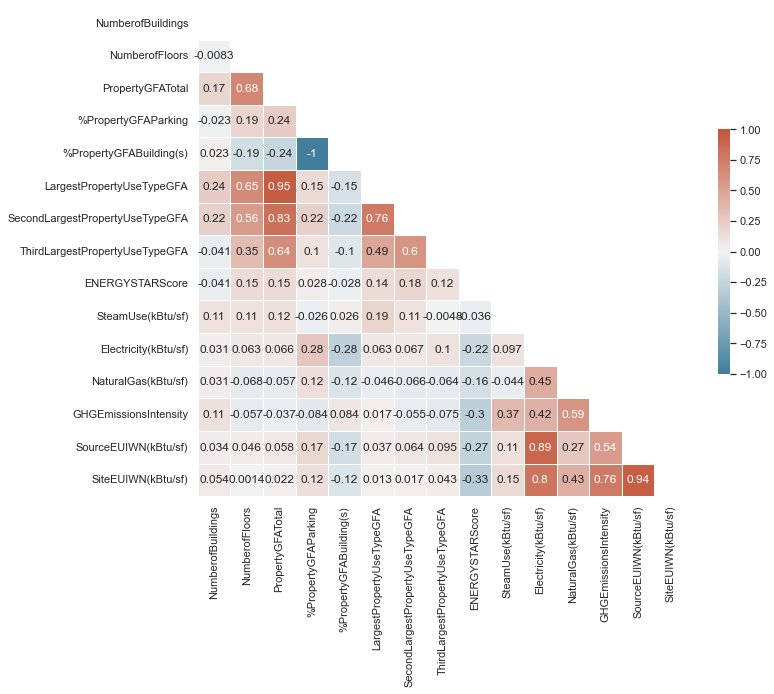

In [31]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df6.iloc[:,10:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# IV. MISE EN FORME DE VARIABLES QUAL EN QUANT (Dumisation)

IV.1 Dumisation de la var quartier 'Neighborhood'

In [32]:
df6['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [33]:
dico = {'North':'NORTH', 'Delridge':'DELRIDGE', 'Ballard':'BALLARD', 'Northwest':'NORTHWEST', 'Central':'CENTRAL', 'DELRIDGE NEIGHBORHOODS':'DELRIDGE'}

In [34]:
df7 = df6.copy()

In [35]:
df7['Neighborhood'] = df7['Neighborhood'].replace(dico)

In [36]:
df7['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE'], dtype=object)

In [37]:
df8 = pd.get_dummies(df7, columns=["Neighborhood"], prefix=[''])

In [38]:
df8.head(2)

,PrimaryPropertyType,PropertyName,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,...,_DOWNTOWN,_EAST,_GREATER DUWAMISH,_LAKE UNION,_MAGNOLIA / QUEEN ANNE,_NORTH,_NORTHEAST,_NORTHWEST,_SOUTHEAST,_SOUTHWEST
0,Hotel,Mayflower park hotel,Hotel,NaN,NaN,7,47.61220,-122.33799,1927,1.0,...,1,0,0,0,0,0,0,0,0,0
1,Hotel,Paramount Hotel,Hotel,Parking,Restaurant,7,47.61317,-122.33393,1996,1.0,...,1,0,0,0,0,0,0,0,0,0


In [39]:
df8.columns[-13:]

Index(['_BALLARD', '_CENTRAL', '_DELRIDGE', '_DOWNTOWN', '_EAST',
       '_GREATER DUWAMISH', '_LAKE UNION', '_MAGNOLIA / QUEEN ANNE', '_NORTH',
       '_NORTHEAST', '_NORTHWEST', '_SOUTHEAST', '_SOUTHWEST'],
      dtype='object')

IV.2 Ne conserver que la var 'Neighborhood' dumisée et supprimer les autres relatives à la localisation.

In [40]:
df9 = df8.drop(columns=['CouncilDistrictCode', 'Latitude', 'Longitude'])

IV.3 Dumisation des col PrimaryPropertyType, 2nd et 3rd

Vérif si données Nan dans col LargestPropertyUseType

In [41]:
df9[df9['LargestPropertyUseType'].isna()]

,PrimaryPropertyType,PropertyName,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,%PropertyGFAParking,...,_DOWNTOWN,_EAST,_GREATER DUWAMISH,_LAKE UNION,_MAGNOLIA / QUEEN ANNE,_NORTH,_NORTHEAST,_NORTHWEST,_SOUTHEAST,_SOUTHWEST
353,Self-Storage Facility,Market St Center,NaN,NaN,NaN,1946,2.0,2,111445,0.0,...,0,0,0,0,0,0,0,0,0,0
1147,Hotel,Palladian Hotel,NaN,NaN,NaN,1910,1.0,8,61721,0.0,...,1,0,0,0,0,0,0,0,0,0
2414,Small- and Mid-Sized Office,Talon Northlake LLC,NaN,NaN,NaN,2008,1.0,4,48350,0.0,...,0,0,0,1,0,0,0,0,0,0
2459,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,NaN,NaN,NaN,1913,1.0,3,28800,0.0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
df10 = df9[df9['LargestPropertyUseType'].notna()] #suppression des 4 lignes avec NaN

In [43]:
df10 = df10.reset_index(drop=True)

Réflexion pour changer le nom des catégories dans les 3 col LargestPropertyUseType, 2ndPropertyUseType et 3rd

In [44]:
liste = df10['LargestPropertyUseType'].value_counts()

In [45]:
liste.head(10)

Office                        483
Non-Refrigerated Warehouse    197
Retail Store                   91
Other                          90
Hotel                          75
Worship Facility               69
Distribution Center            54
K-12 School                    46
Supermarket/Grocery Store      41
Medical Office                 41
Name: LargestPropertyUseType, dtype: int64

/!\ Idée : définir une dizaine de gdes familles:
- Office
- Non-Refrigerated Warehouse
- Other (fourre-tout)
- Store (retail, supermarket...)
- Medical (med office, hospital)
- Schools
- Worship Facility
- Parking...

In [46]:
df_l = liste.to_frame()
df_l = df_l.reset_index()

In [47]:
dico2 = {}
for elt in df_l['index']:
    dico2[elt] = elt

Créer un dico2 pour changer les noms en gdes familles définies

In [48]:
dico2['Retail Store']='Store'
dico2['Distribution Center']='Industrial Plant'
dico2['K-12 School'] = 'School'
dico2['Supermarket/Grocery Store']='Store'
dico2['Self-Storage Facility'] = 'Other'
dico2['College/University']='School'
dico2['Other - Entertainment/Public Assembly']='Other - Recreation'
dico2['Senior Care Community']='Medical Office'
dico2['Laboratory']='Industrial Plant'
dico2['Refrigerated Warehouse']='Industrial Plant'
dico2['Multifamily Housing']='Residence Hall/Dormitory'
dico2['Other - Entertainment/Public Assembly']='Other - Recreation'
dico2['Hospital (General Medical & Surgical)']='Medical Office'
dico2['Social/Meeting Hall']='Other - Recreation'
dico2['Manufacturing/Industrial Plant']='Industrial Plant'
dico2['Repair Services (Vehicle, Shoe, Locksmith, etc)']='Store'
dico2['Strip Mall']='Store'
dico2['Automobile Dealership']='Store'
dico2['Fitness Center/Health Club/Gym']='Other - Recreation'
dico2['Other - Services']='Other'
dico2['Other - Lodging/Residential']='Residence Hall/Dormitory'
dico2['Museum']='Other - Recreation'
dico2['Other - Mall']='Store'
dico2['Urgent Care/Clinic/Other Outpatient']='Medical Office'
dico2['Bank Branch']='Office'
dico2['Financial Office']='Office'
dico2['Other/Specialty Hospital']='Medical Office'
dico2['Library']='Other - Recreation'
dico2['Data Center']='Industrial Plant'
dico2['Performing Arts']='Other - Recreation'
dico2['Other - Education']='School'
dico2['Prison/Incarceration']=='Other'
dico2['Other - Public Services']='Other'
dico2['Lifestyle Center']='Other - Recreation'
dico2['Other - Restaurant/Bar']='Restaurant'
dico2['Adult Education']='School'
dico2['Other - Utility']='Other'
dico2['Pre-school/Daycare']='School'
dico2['Courthouse']='Other'
dico2['Residential Care Facility']='Store'
dico2['Wholesale Club/Supercenter']='Store'
dico2['Police Station']='Other'
dico2['Food Service']='Restaurant'
dico2['Prison/Incarceration']='Other'
dico2['Movie Theater']='Other - Recreation'
dico2['Personal Services (Health/Beauty, Dry Cleaning, etc)']='Store'
dico2['Fire Station']='Other'

Vérif des val du dico2

In [49]:
l2 = []
for key, val in dico2.items():
    l2.append(val)
set(l2), len(set(l2))

({'Hotel',
  'Industrial Plant',
  'Medical Office',
  'Non-Refrigerated Warehouse',
  'Office',
  'Other',
  'Other - Recreation',
  'Parking',
  'Residence Hall/Dormitory',
  'Restaurant',
  'School',
  'Store',
  'Worship Facility'},
 13)

13 familles : très bien!!

Faire une 1ère phase de remplacement des noms dans les 3 col LargestPropertyUseType, 2nd et 3rd

In [50]:
df11=df10.copy()

In [51]:
df11.iloc[:,2:5]=df11.iloc[:,2:5].replace(dico2)

In [52]:
df11['LargestPropertyUseType'].value_counts()

Office                        491
Non-Refrigerated Warehouse    197
Store                         156
Other                         132
Industrial Plant               89
Other - Recreation             82
Medical Office                 79
Hotel                          75
School                         70
Worship Facility               69
Residence Hall/Dormitory       37
Parking                        29
Restaurant                     14
Name: LargestPropertyUseType, dtype: int64

Vérif dans les col LargestPropertyUseType, 2nd et 3rd

In [53]:
df11['LargestPropertyUseType'].unique(), df11['SecondLargestPropertyUseType'].unique(), df11['ThirdLargestPropertyUseType'].unique()

(array(['Hotel', 'Other', 'Other - Recreation', 'School', 'Store',
        'Office', 'Non-Refrigerated Warehouse', 'Medical Office',
        'Residence Hall/Dormitory', 'Industrial Plant', 'Parking',
        'Worship Facility', 'Restaurant'], dtype=object),
 array([nan, 'Parking', 'Office', 'Restaurant', 'School',
        'Industrial Plant', 'Non-Refrigerated Warehouse',
        'Vocational School', 'Store', 'Other - Recreation',
        'Swimming Pool', 'Other', 'Residence Hall/Dormitory',
        'Medical Office', 'Convenience Store without Gas Station',
        'Enclosed Mall', 'Bar/Nightclub', 'Hotel', 'Worship Facility',
        'Food Sales'], dtype=object),
 array([nan, 'Restaurant', 'Swimming Pool', 'Industrial Plant', 'Office',
        'Store', 'Other - Recreation', 'Other', 'Medical Office',
        'Parking', 'School', 'Convenience Store without Gas Station',
        'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'Hotel',
        'Other - Technology/Science', 'Bar/

Continuer à remplacer dans col second et third en enrichissant dico2

In [54]:
dico2['Swimming Pool']='Other - Recreation'
dico2['Convenience Store without Gas Station']='Store'
dico2['Other - Technology/Science']='Industrial Plant'
dico2['Bar/Nightclub']='Other - Recreation'
dico2['Fast Food Restaurant']='Restaurant'
dico2['Vocational School']='School'
dico2['Enclosed Mall']='Store'
dico2['Food Sales']='Store'

2e phase de remplacement des noms de catégories pra ceux des 13 gdes familles, dans les 2 col SecondLargestPropertyUseType et 3rd.

In [55]:
df11.iloc[:,3:5]=df11.iloc[:,3:5].replace(dico2)

In [56]:
df11['SecondLargestPropertyUseType'].unique(), df11['ThirdLargestPropertyUseType'].unique()

(array([nan, 'Parking', 'Office', 'Restaurant', 'School',
        'Industrial Plant', 'Non-Refrigerated Warehouse', 'Store',
        'Other - Recreation', 'Other', 'Residence Hall/Dormitory',
        'Medical Office', 'Hotel', 'Worship Facility'], dtype=object),
 array([nan, 'Restaurant', 'Other - Recreation', 'Industrial Plant',
        'Office', 'Store', 'Other', 'Medical Office', 'Parking', 'School',
        'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'Hotel',
        'Worship Facility'], dtype=object))

In [57]:
df11.head(3)

,PrimaryPropertyType,PropertyName,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,%PropertyGFAParking,...,_DOWNTOWN,_EAST,_GREATER DUWAMISH,_LAKE UNION,_MAGNOLIA / QUEEN ANNE,_NORTH,_NORTHEAST,_NORTHWEST,_SOUTHEAST,_SOUTHWEST
0,Hotel,Mayflower park hotel,Hotel,NaN,NaN,1927,1.0,12,88434,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,Hotel,Paramount Hotel,Hotel,Parking,Restaurant,1996,1.0,11,103566,14.545314,...,1,0,0,0,0,0,0,0,0,0
2,Hotel,5673-The Westin Seattle,Hotel,NaN,NaN,1969,1.0,41,956110,20.574829,...,1,0,0,0,0,0,0,0,0,0


Pour éviter des difficultées, imputation dans 4 col stratégiques.

In [58]:
df11['SecondLargestPropertyUseType'] = df11['SecondLargestPropertyUseType'].fillna('Unknown')
df11['ThirdLargestPropertyUseType'] = df11['ThirdLargestPropertyUseType'].fillna('Unknown')
df11['SecondLargestPropertyUseTypeGFA'] = df11['SecondLargestPropertyUseTypeGFA'].fillna(0)
df11['ThirdLargestPropertyUseTypeGFA'] = df11['ThirdLargestPropertyUseTypeGFA'].fillna(0)

/!\ Dumiser les 13 gdes familles des col LargestPropertyUseType, 2nd et 3rd en récupérant <br> 
les valeurs des col LargestPropertyUseTypeGFA, 2nd...GFA et 3rd...GFA

In [59]:
dico3 = {}
for elt in df11['SecondLargestPropertyUseType'].unique():
    dico3[elt]=[]

In [60]:
for i in range(0, len(df11)):
    l3 = list(df11['SecondLargestPropertyUseType'].unique())
    l5 = []
    x = df11.at[i,'LargestPropertyUseType']
    y = df11.at[i,'SecondLargestPropertyUseType']
    z = df11.at[i,'ThirdLargestPropertyUseType']
    x_val = df11.at[i,'LargestPropertyUseTypeGFA']
    y_val = df11.at[i,'SecondLargestPropertyUseTypeGFA']
    z_val = df11.at[i,'ThirdLargestPropertyUseTypeGFA']
    if x == y and y == z:
        l5.append(x)
        dico3[x].append(x_val+y_val+z_val)
    elif x == y and y != z:
        l5.append(x)
        dico3[x].append(x_val+y_val)
        l5.append(z)
        dico3[z].append(z_val)
    elif x != y and y == z:
        l5.append(x)
        dico3[x].append(x_val)
        l5.append(y)
        dico3[y].append(y_val+z_val)
    elif x != y and y != z and x != z:
        l5.append(x)
        dico3[x].append(x_val)
        l5.append(y)
        dico3[y].append(y_val)
        l5.append(z)
        dico3[z].append(z_val)
    elif x != y and y != z and x == z:
        l5.append(x)
        dico3[x].append(x_val+z_val)
        l5.append(y)
        dico3[y].append(y_val)
    l3 = [ele for ele in l3 if ele not in l5]
    for elt2 in l3:
        dico3[elt2].append(0)


In [61]:
dumies = pd.DataFrame.from_dict(dico3)

In [62]:
dumies.head(3)

,Unknown,Parking,Office,Restaurant,School,Industrial Plant,Non-Refrigerated Warehouse,Store,Other - Recreation,Other,Residence Hall/Dormitory,Medical Office,Hotel,Worship Facility
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0,0.0
1,0.0,15064.0,0.0,4622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83880.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,756493.0,0.0


In [63]:
df12 = pd.merge(df11, dumies, left_index=True, right_index=True)

In [64]:
df12.head(3)

,PrimaryPropertyType,PropertyName,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,%PropertyGFAParking,...,School,Industrial Plant,Non-Refrigerated Warehouse,Store,Other - Recreation,Other,Residence Hall/Dormitory,Medical Office,Hotel,Worship Facility
0,Hotel,Mayflower park hotel,Hotel,Unknown,Unknown,1927,1.0,12,88434,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0,0.0
1,Hotel,Paramount Hotel,Hotel,Parking,Restaurant,1996,1.0,11,103566,14.545314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83880.0,0.0
2,Hotel,5673-The Westin Seattle,Hotel,Unknown,Unknown,1969,1.0,41,956110,20.574829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,756493.0,0.0


In [65]:
df12.columns

Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       '%PropertyGFAParking', '%PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)',
       'GHGEmissionsIntensity', 'SourceEUIWN(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       '_BALLARD', '_CENTRAL', '_DELRIDGE', '_DOWNTOWN', '_EAST',
       '_GREATER DUWAMISH', '_LAKE UNION', '_MAGNOLIA / QUEEN ANNE', '_NORTH',
       '_NORTHEAST', '_NORTHWEST', '_SOUTHEAST', '_SOUTHWEST', 'Unknown',
       'Parking', 'Office', 'Restaurant', 'School', 'Industrial Plant',
       'Non-Refrigerated Warehouse', 'Store', 'Other - Recreation', 'Other',
       'Residence Hall/Dormitory', 'Medical Office', 'Hotel',
       '

# V. MISE EN FORME FINALE DU DF

V.1. Suppression des col inutiles

In [66]:
df13 = df12.copy()

In [67]:
df13['Unknown'].unique()

array([0.])

In [68]:
df13=df13.drop(columns=['SecondLargestPropertyUseType', 
'ThirdLargestPropertyUseType', 'PropertyGFATotal', 'Unknown',
'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
'%PropertyGFAParking', '%PropertyGFABuilding(s)'
])

V.2. Modifier la col YearBuilt en age par rapport à 2016.

In [69]:
df13.insert(3, 'Age', 2016-df13.pop('YearBuilt'))

V.3. Passer les sources énergétiques en %.

In [70]:
df14=df13.copy()

In [71]:
df14.insert(7, '%SteamUse', df13['SteamUse(kBtu/sf)']/(df13['SteamUse(kBtu/sf)']+df13['Electricity(kBtu/sf)']+df13['NaturalGas(kBtu/sf)'])*100)
df14.insert(8, '%Electricity', df13['Electricity(kBtu/sf)']/(df13['SteamUse(kBtu/sf)']+df13['Electricity(kBtu/sf)']+df13['NaturalGas(kBtu/sf)'])*100)
df14.insert(9, '%NaturalGas', df13['NaturalGas(kBtu/sf)']/(df13['SteamUse(kBtu/sf)']+df13['Electricity(kBtu/sf)']+df13['NaturalGas(kBtu/sf)'])*100)

df14=df14.drop(columns=['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)'])

In [72]:
df14.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1520.0,54.301316,32.807958,1.00,28.000000,50.500000,86.000000,1.160000e+02
NumberofBuildings,1520.0,1.033553,0.564059,0.00,1.000000,1.000000,1.000000,9.000000e+00
NumberofFloors,1520.0,4.304605,6.833676,0.00,1.000000,2.000000,4.000000,9.900000e+01
ENERGYSTARScore,990.0,63.660606,28.832699,1.00,44.000000,71.000000,88.000000,1.000000e+02
%SteamUse,1519.0,2.276227,9.533341,0.00,0.000000,0.000000,0.000000,7.669877e+01
%Electricity,1519.0,70.435014,26.312146,0.00,49.170228,71.227270,100.000000,1.000000e+02
%NaturalGas,1519.0,27.288759,26.436667,0.00,0.000000,22.864195,48.880286,1.000000e+02
GHGEmissionsIntensity,1520.0,1.629908,2.255143,-0.02,0.350000,0.875000,1.950000,2.571000e+01
SourceEUIWN(kBtu/sf),1520.0,184.709934,188.771785,-2.10,83.424999,140.900002,212.749996,2.620000e+03
SiteEUIWN(kBtu/sf),1519.0,77.128703,76.350601,0.00,36.799999,56.099998,87.699997,8.344000e+02


V.4. Passer les GFA de chq catégorie (parking, store...) en %.

In [73]:
df15 = df14.copy()

In [74]:
df15.columns

Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType', 'Age',
       'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore', '%SteamUse',
       '%Electricity', '%NaturalGas', 'GHGEmissionsIntensity',
       'SourceEUIWN(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', '_BALLARD', '_CENTRAL',
       '_DELRIDGE', '_DOWNTOWN', '_EAST', '_GREATER DUWAMISH', '_LAKE UNION',
       '_MAGNOLIA / QUEEN ANNE', '_NORTH', '_NORTHEAST', '_NORTHWEST',
       '_SOUTHEAST', '_SOUTHWEST', 'Parking', 'Office', 'Restaurant', 'School',
       'Industrial Plant', 'Non-Refrigerated Warehouse', 'Store',
       'Other - Recreation', 'Other', 'Residence Hall/Dormitory',
       'Medical Office', 'Hotel', 'Worship Facility'],
      dtype='object')

In [75]:
dico4 = {}
dico4['Parking']='%Parking'
dico4['Office']='%Office'
dico4['Restaurant']='%Restaurant'
dico4['School']='%School'
dico4['Industrial Plant']='%Industrial_Plant'
dico4['Non-Refrigerated Warehouse']='%Non-Refrigerated_Warehouse'
dico4['Store']='%Store'
dico4['Other - Recreation']='%Recreation'
dico4['Other']='%Other'
dico4['Residence Hall/Dormitory']='%Residence'
dico4['Medical Office']='%Medical_Office'
dico4['Hotel']='%Hotel'
dico4['Worship Facility']='%Worship_Facility'

In [76]:
cat = df15['Parking']+df15['Office']+df15['Restaurant']+df15['School']+df15['Industrial Plant']+df15['Non-Refrigerated Warehouse']+df15['Store']+df15['Other - Recreation']+df15['Other']+df15['Residence Hall/Dormitory']+df15['Medical Office']+df15['Hotel']+df15['Worship Facility']

In [77]:
for elt,i in zip(df15.columns[26:], range(10,23)):
    df15.insert(i, dico4[elt], df15[elt]/cat*100)

In [78]:
df15.columns

Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType', 'Age',
       'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore', '%SteamUse',
       '%Electricity', '%NaturalGas', '%Parking', '%Office', '%Restaurant',
       '%School', '%Industrial_Plant', '%Non-Refrigerated_Warehouse', '%Store',
       '%Recreation', '%Other', '%Residence', '%Medical_Office', '%Hotel',
       '%Worship_Facility', 'GHGEmissionsIntensity', 'SourceEUIWN(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', '_BALLARD', '_CENTRAL', '_DELRIDGE', '_DOWNTOWN',
       '_EAST', '_GREATER DUWAMISH', '_LAKE UNION', '_MAGNOLIA / QUEEN ANNE',
       '_NORTH', '_NORTHEAST', '_NORTHWEST', '_SOUTHEAST', '_SOUTHWEST',
       'Parking', 'Office', 'Restaurant', 'School', 'Industrial Plant',
       'Non-Refrigerated Warehouse', 'Store', 'Other - Recreation', 'Other',
       'Residence Hall/Dormitory', 'Medical Office', 'Hotel',
       'Worship Facility'],
      dtype='object')

Suppression des anciennes col Parking, Office...

In [79]:
df16=df15.drop(columns=[elt for elt in df15.columns[df15.columns.get_loc("Parking"):]])

V.5. Mise en forme des noms de colonnes (_BALLARD => Ballard...)

In [80]:
dico5={}
for elt in df16.columns[26:]:
    elt2 = elt.lower()
    elt3 = list(elt2)
    elt4 = elt3[1:]
    elt5 = ''.join(elt4)
    elt6 = elt5.capitalize()
    dico5[elt]=elt6

In [81]:
dico5

{'_BALLARD': 'Ballard',
 '_CENTRAL': 'Central',
 '_DELRIDGE': 'Delridge',
 '_DOWNTOWN': 'Downtown',
 '_EAST': 'East',
 '_GREATER DUWAMISH': 'Greater duwamish',
 '_LAKE UNION': 'Lake union',
 '_MAGNOLIA / QUEEN ANNE': 'Magnolia / queen anne',
 '_NORTH': 'North',
 '_NORTHEAST': 'Northeast',
 '_NORTHWEST': 'Northwest',
 '_SOUTHEAST': 'Southeast',
 '_SOUTHWEST': 'Southwest'}

In [82]:
dico5['_GREATER DUWAMISH']='Greater_Duwamish'
dico5['_MAGNOLIA / QUEEN ANNE']='Magnolia#Queen_Anne'
dico5['_LAKE UNION']='Lake_Union'

In [83]:
df16 = df16.rename(columns=dico5)

In [84]:
df16.columns

Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType', 'Age',
       'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore', '%SteamUse',
       '%Electricity', '%NaturalGas', '%Parking', '%Office', '%Restaurant',
       '%School', '%Industrial_Plant', '%Non-Refrigerated_Warehouse', '%Store',
       '%Recreation', '%Other', '%Residence', '%Medical_Office', '%Hotel',
       '%Worship_Facility', 'GHGEmissionsIntensity', 'SourceEUIWN(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'Ballard', 'Central', 'Delridge', 'Downtown',
       'East', 'Greater_Duwamish', 'Lake_Union', 'Magnolia#Queen_Anne',
       'North', 'Northeast', 'Northwest', 'Southeast', 'Southwest'],
      dtype='object')

# VI. GESTION DES NAN, TRANSFORMATION DES FEATURES ET ORGANISATION DES COL Y

VI.1. Suppression des rows qui ont au moins une valeurs ou négatives nulles dans les y

In [85]:
df16['GHGEmissionsIntensity'].min()

-0.02

In [86]:
df16['GHGEmissionsIntensity'].max()

25.71

In [87]:
df16.shape

(1520, 39)

In [88]:
df17 = df16[(df16['GHGEmissionsIntensity']>0) & (df16['SourceEUIWN(kBtu/sf)']>0) & (df16['SiteEUIWN(kBtu/sf)']>0)]

In [89]:
df17.shape

(1508, 39)

In [90]:
df17.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1508.0,54.362069,32.784555,1.00,28.000000,51.000000,86.000000,116.000000
NumberofBuildings,1508.0,1.033820,0.566292,0.00,1.000000,1.000000,1.000000,9.000000
NumberofFloors,1508.0,4.280504,6.833713,0.00,1.000000,2.000000,4.000000,99.000000
ENERGYSTARScore,981.0,63.574924,28.884424,1.00,43.000000,71.000000,88.000000,100.000000
%SteamUse,1508.0,2.229053,9.418367,0.00,0.000000,0.000000,0.000000,76.698765
%Electricity,1508.0,70.367162,26.315069,0.00,49.138308,71.121140,100.000000,100.000000
%NaturalGas,1508.0,27.403784,26.438068,0.00,0.000000,23.182551,48.981371,100.000000
%Parking,1508.0,5.837414,13.077279,0.00,0.000000,0.000000,0.000000,81.007600
%Office,1508.0,28.953898,37.814792,0.00,0.000000,0.000000,64.654587,100.000000
%Restaurant,1508.0,1.297864,8.552240,0.00,0.000000,0.000000,0.000000,100.000000


VI.2. Réorganisation des colonnes du df (X à gauche et Y à droite)

In [91]:
df17.columns.get_loc("Southwest")

38

In [92]:
df17.insert(38, 'GHGEmissionsIntensity', df17.pop('GHGEmissionsIntensity'))
df17.insert(38, 'SiteEUIWN(kBtu/sf)', df17.pop('SiteEUIWN(kBtu/sf)'))
df17.insert(38, 'SourceEUIWN(kBtu/sf)', df17.pop('SourceEUIWN(kBtu/sf)'))

df17.insert(3, 'ENERGYSTARScore', df17.pop('ENERGYSTARScore')) #mettre la col EnergyStarScore à gauche du df pour plus de facilitées

In [93]:
df17.columns

Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType',
       'ENERGYSTARScore', 'Age', 'NumberofBuildings', 'NumberofFloors',
       '%SteamUse', '%Electricity', '%NaturalGas', '%Parking', '%Office',
       '%Restaurant', '%School', '%Industrial_Plant',
       '%Non-Refrigerated_Warehouse', '%Store', '%Recreation', '%Other',
       '%Residence', '%Medical_Office', '%Hotel', '%Worship_Facility',
       'Ballard', 'Central', 'Delridge', 'Downtown', 'East',
       'Greater_Duwamish', 'Lake_Union', 'Magnolia#Queen_Anne', 'North',
       'Northeast', 'Northwest', 'Southeast', 'Southwest',
       'GHGEmissionsIntensity', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'],
      dtype='object')

VI.3. Gestion des NaN dan col EnergyStarScore

Je n'enlève rien finalement : cela sera fait plus tard au moment du ML (cf notebooks_prediction).

In [94]:
#df18 = df17[df17['ENERGYSTARScore'].notna()]

VI.4. Transformation Log2 de certaines features

In [95]:
df17.columns, df17.columns.get_loc('GHGEmissionsIntensity')

(Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType',
        'ENERGYSTARScore', 'Age', 'NumberofBuildings', 'NumberofFloors',
        '%SteamUse', '%Electricity', '%NaturalGas', '%Parking', '%Office',
        '%Restaurant', '%School', '%Industrial_Plant',
        '%Non-Refrigerated_Warehouse', '%Store', '%Recreation', '%Other',
        '%Residence', '%Medical_Office', '%Hotel', '%Worship_Facility',
        'Ballard', 'Central', 'Delridge', 'Downtown', 'East',
        'Greater_Duwamish', 'Lake_Union', 'Magnolia#Queen_Anne', 'North',
        'Northeast', 'Northwest', 'Southeast', 'Southwest',
        'GHGEmissionsIntensity', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'],
       dtype='object'),
 36)

Transformation des col y en log2 y

In [96]:
df18 = df17.copy()

In [97]:
df18.insert(36, 'Log2_GHGEmissionsIntensity', np.log2(df18.pop('GHGEmissionsIntensity')))
df18.insert(37, 'Log2_SiteEUIWN', np.log2(df18.pop('SiteEUIWN(kBtu/sf)')))
df18.insert(38, 'Log2_SourceEUIWN', np.log2(df18.pop('SourceEUIWN(kBtu/sf)')))

Transformation des col ages-> nb floors en log2 <br>
/!\ gérer les données trop dispercées

passer les données nulles en 1 (col NbBuidlings & NbFloors)

In [98]:
def replace_Zero():
    df = df18.copy()
    for elt in df.columns[5:7]:
        df[elt] = df[elt].apply(lambda x : x if x != 0 else 1)
    return df

In [99]:
df19 = replace_Zero()

In [100]:
df19.insert(4, 'Log2_Age', np.log2(df19.pop('Age')))
df19.insert(5, 'Log2_#Buildings', np.log2(df19.pop('NumberofBuildings')))
df19.insert(6, 'Log2_#Floors', np.log2(df19.pop('NumberofFloors')))

# VII. EDA des features X et y

In [101]:
df19.describe().T

,count,mean,std,min,25%,50%,75%,max
ENERGYSTARScore,981.0,63.574924,28.884424,1.000000,43.000000,71.000000,88.000000,100.000000
Log2_Age,1508.0,5.365663,1.267457,0.000000,4.807355,5.672425,6.426265,6.857981
Log2_#Buildings,1508.0,0.042742,0.290972,0.000000,0.000000,0.000000,0.000000,3.169925
Log2_#Floors,1508.0,1.408487,1.245165,0.000000,0.000000,1.000000,2.000000,6.629357
%SteamUse,1508.0,2.229053,9.418367,0.000000,0.000000,0.000000,0.000000,76.698765
%Electricity,1508.0,70.367162,26.315069,0.000000,49.138308,71.121140,100.000000,100.000000
%NaturalGas,1508.0,27.403784,26.438068,0.000000,0.000000,23.182551,48.981371,100.000000
%Parking,1508.0,5.837414,13.077279,0.000000,0.000000,0.000000,0.000000,81.007600
%Office,1508.0,28.953898,37.814792,0.000000,0.000000,0.000000,64.654587,100.000000
%Restaurant,1508.0,1.297864,8.552240,0.000000,0.000000,0.000000,0.000000,100.000000


In [102]:
#msno.matrix(df20)

In [103]:
def box_histplot(table=df19, var='Log2_SiteEUIWN'):
    fig = go.Figure() 
    fig.add_trace(go.Box(y=list(table[var]), boxpoints='all', 
                     name=var, boxmean='sd'))
    sns.histplot(data=table, x=var, kde=True) 
    return fig.show()

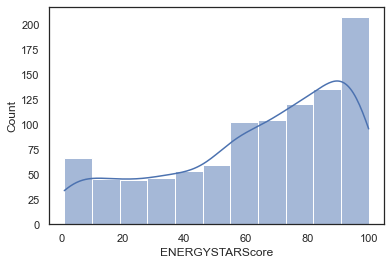

In [104]:
box_histplot(table=df19, var="ENERGYSTARScore")

<AxesSubplot:>

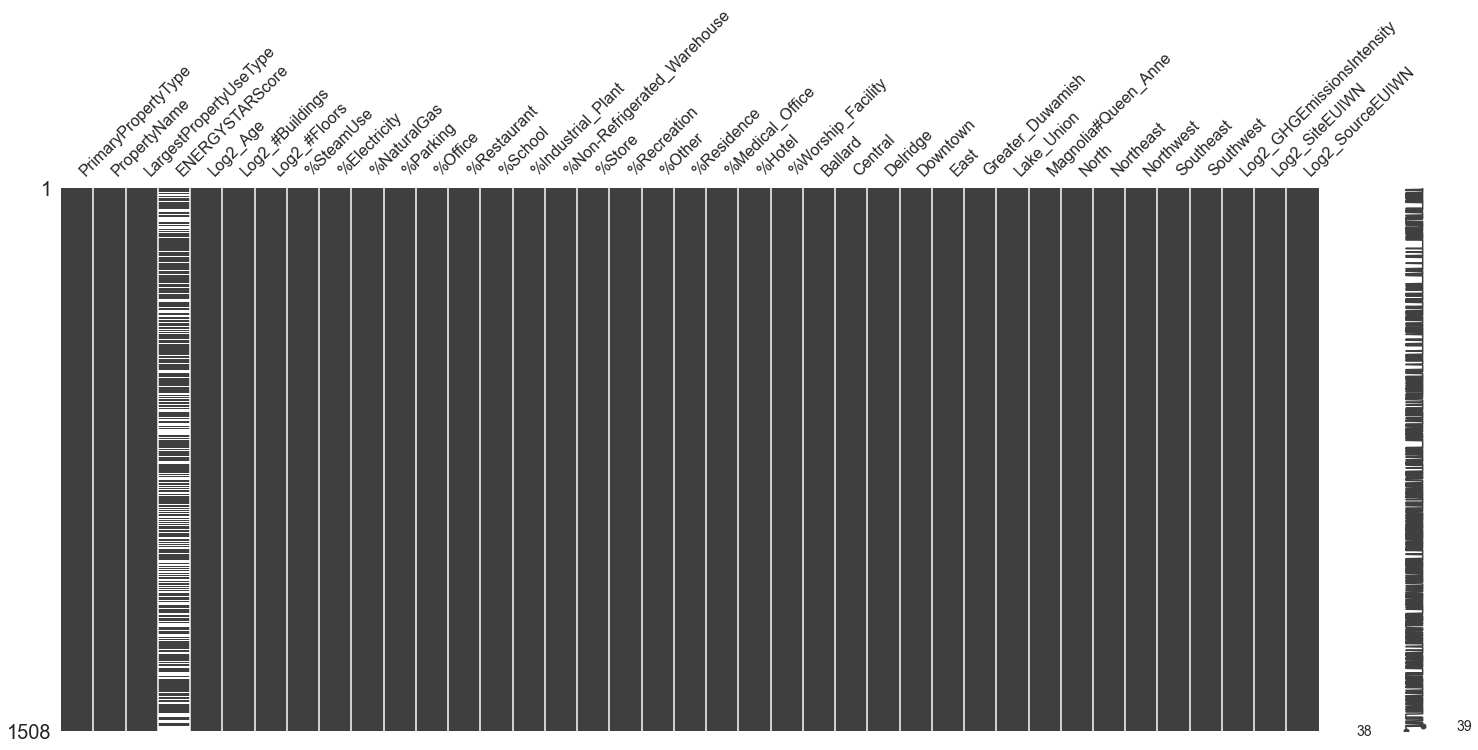

In [105]:
msno.matrix(df19)

In [106]:
df19.columns

Index(['PrimaryPropertyType', 'PropertyName', 'LargestPropertyUseType',
       'ENERGYSTARScore', 'Log2_Age', 'Log2_#Buildings', 'Log2_#Floors',
       '%SteamUse', '%Electricity', '%NaturalGas', '%Parking', '%Office',
       '%Restaurant', '%School', '%Industrial_Plant',
       '%Non-Refrigerated_Warehouse', '%Store', '%Recreation', '%Other',
       '%Residence', '%Medical_Office', '%Hotel', '%Worship_Facility',
       'Ballard', 'Central', 'Delridge', 'Downtown', 'East',
       'Greater_Duwamish', 'Lake_Union', 'Magnolia#Queen_Anne', 'North',
       'Northeast', 'Northwest', 'Southeast', 'Southwest',
       'Log2_GHGEmissionsIntensity', 'Log2_SiteEUIWN', 'Log2_SourceEUIWN'],
      dtype='object')

<AxesSubplot:>

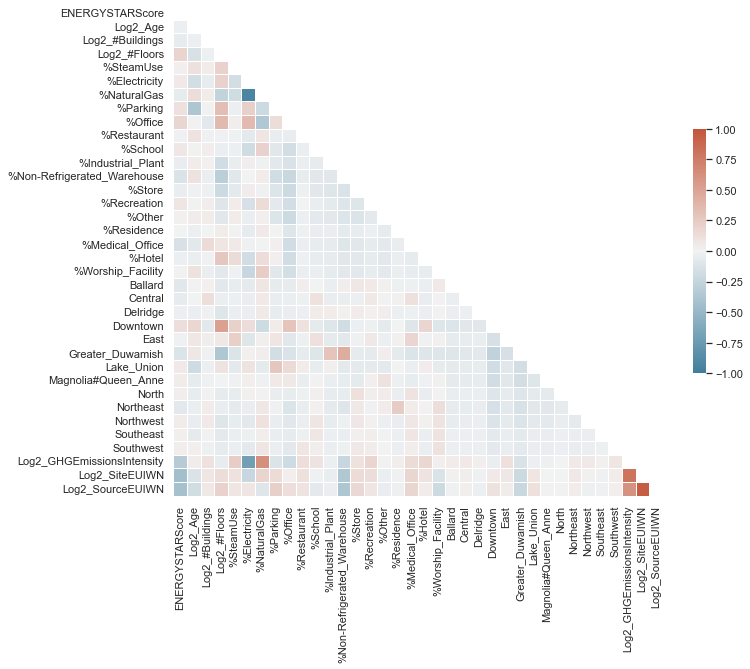

In [107]:
sns.set_theme(style="white")


# Compute the correlation matrix
corr = df19.iloc[:,3:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

In [108]:
df19.describe().T

,count,mean,std,min,25%,50%,75%,max
ENERGYSTARScore,981.0,63.574924,28.884424,1.000000,43.000000,71.000000,88.000000,100.000000
Log2_Age,1508.0,5.365663,1.267457,0.000000,4.807355,5.672425,6.426265,6.857981
Log2_#Buildings,1508.0,0.042742,0.290972,0.000000,0.000000,0.000000,0.000000,3.169925
Log2_#Floors,1508.0,1.408487,1.245165,0.000000,0.000000,1.000000,2.000000,6.629357
%SteamUse,1508.0,2.229053,9.418367,0.000000,0.000000,0.000000,0.000000,76.698765
%Electricity,1508.0,70.367162,26.315069,0.000000,49.138308,71.121140,100.000000,100.000000
%NaturalGas,1508.0,27.403784,26.438068,0.000000,0.000000,23.182551,48.981371,100.000000
%Parking,1508.0,5.837414,13.077279,0.000000,0.000000,0.000000,0.000000,81.007600
%Office,1508.0,28.953898,37.814792,0.000000,0.000000,0.000000,64.654587,100.000000
%Restaurant,1508.0,1.297864,8.552240,0.000000,0.000000,0.000000,0.000000,100.000000


# VIII. Générer un fichier csv

Pour les 2 notebooks de prédiction

In [109]:
df19.shape

(1508, 39)

In [110]:
df19.to_csv('df19.csv', index=False, header=True)